In [1]:
%matplotlib inline
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from itertools import chain
from scipy import stats
from nltk.stem import WordNetLemmatizer
from Recipe2Cuisine_functions import preprocess, plot_confusion_matrix

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline, Pipeline
import warnings
from sklearn.linear_model import LogisticRegression

# Load in Data

In [2]:
# Load json data file
filename = 'recipies.json'
data = pd.read_json(filename)
data.head()

,cuisine,id,ingredients
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,indian,22213,"[water, vegetable oil, wheat, salt]"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe..."


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


In [4]:
# Check if NaN values exist
data.isna().any()

cuisine        False
id             False
ingredients    False
dtype: bool

# EDA

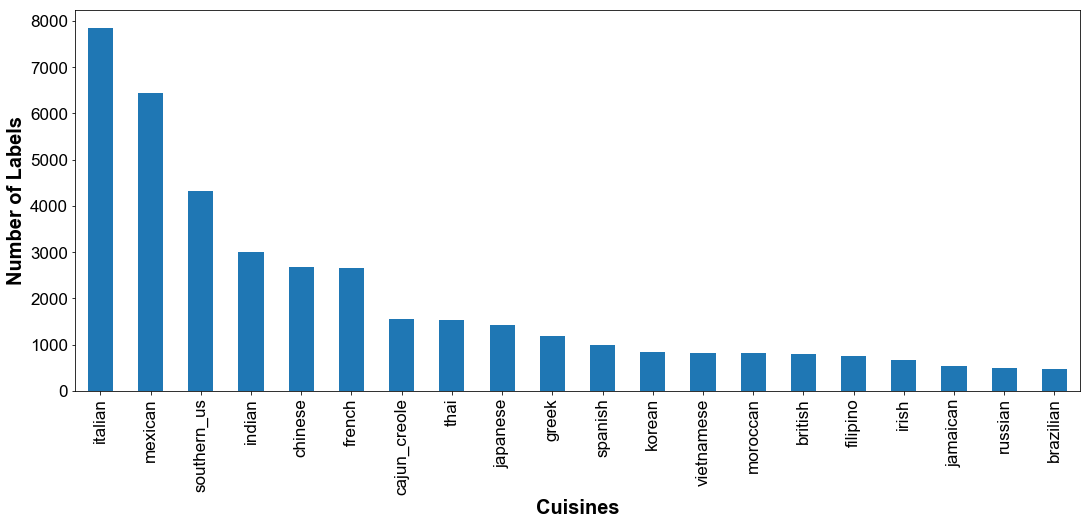

In [5]:
# Counts of the number of cuisine labels 
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
data['cuisine'].value_counts().plot(kind='bar');
sns.set_style("whitegrid") 
plt.xticks(rotation = '90', fontsize = 17);
plt.yticks(fontsize = 17);
ax.set_xlabel('Cuisines', fontsize = 20, weight='bold');
ax.set_ylabel('Number of Labels', fontsize = 20, weight='bold');


In [6]:
# Count of how many ingredients per receipe in each cuisine 
data['Count'] = data['ingredients'].apply(len)
data.head()

,cuisine,id,ingredients,Count
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12
3,indian,22213,"[water, vegetable oil, wheat, salt]",4
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20


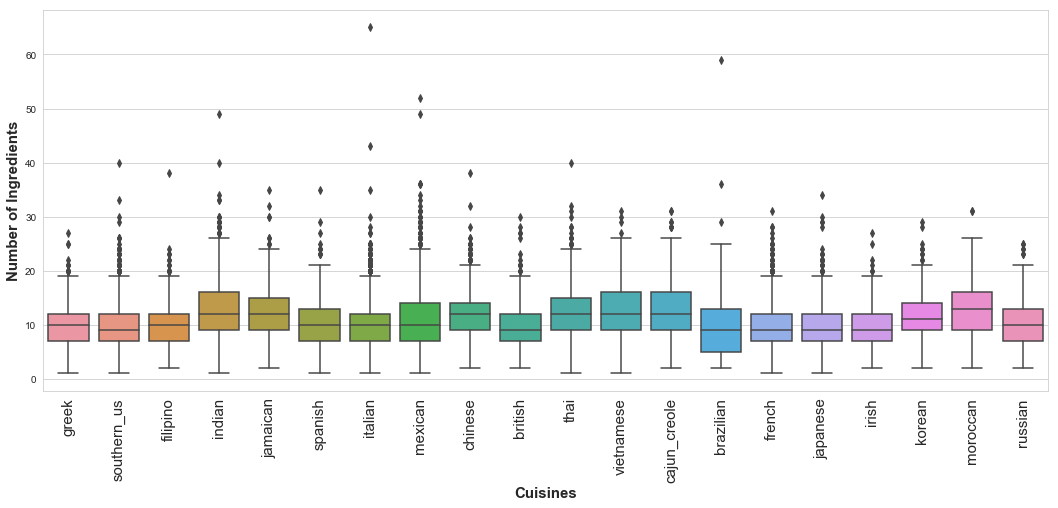

In [7]:
# Plot boxplots grouped by the types of cuisine  
fig, ax = plt.subplots()
fig.set_size_inches(18, 7)
sns.set_style("whitegrid") 
sns.boxplot(x = 'cuisine', y = 'Count', data = data);
ax.set_xlabel('Cuisines', fontsize = 15, weight='bold');
ax.set_ylabel('Number of Ingredients', fontsize = 15, weight='bold');
plt.xticks(rotation = '90', fontsize = 15);
plt.xticks(fontsize = 15);

# Pre-processing 

In [8]:
# Clean data using word lemmatization
data['ingredients_clean']=data['ingredients'].apply(preprocess)
data.head()

,cuisine,id,ingredients,Count,ingredients_clean
0,greek,10259,"[romaine lettuce, black olives, grape tomatoes...",9,"romaine lettuce,black olives,grape tomatoes,ga..."
1,southern_us,25693,"[plain flour, ground pepper, salt, tomatoes, g...",11,"plain flour,ground pepper,salt,tomato,ground b..."
2,filipino,20130,"[eggs, pepper, salt, mayonaise, cooking oil, g...",12,"egg,pepper,salt,mayonaise,cooking oil,green ch..."
3,indian,22213,"[water, vegetable oil, wheat, salt]",4,"water,vegetable oil,wheat,salt"
4,indian,13162,"[black pepper, shallots, cornflour, cayenne pe...",20,"black pepper,shallot,cornflour,cayenne pepper,..."


In [23]:
# List of unique cuisine
cusine_unique = list(data.cuisine.value_counts().index)

# Plot histograms of top 10 ingredients for each cuisine
counter = 0
vocab = [] 

for c in cusine_unique:
    subset = data[data.cuisine == c]
    sub = []
    
    for item in subset.ingredients_clean:
        sub.append(item.split(','))
    A = pd.DataFrame(list(chain.from_iterable(sub)))

    #vocab.append(A[0].value_counts().iloc[:35].index)
    vocab.append(A[0]) 
    counter = counter + 1
    

# TF-IDF

In [10]:
# Define vocabulary for each cuisine
all_vocab = set(list(chain.from_iterable(vocab)))

# grab corpus of all ingredients
all_ingredients = []
for items in data['ingredients_clean']:
    all_ingredients.append(items)

# Count Frequency of words
cv = CountVectorizer(vocabulary = all_vocab, max_df = 0.8)
wordcount_vector = cv.fit_transform(all_ingredients)
print(wordcount_vector.shape)

tfidf_transformer=TfidfTransformer(smooth_idf = True, use_idf = True)
tfidf_transformer.fit(wordcount_vector)

# Print idf values
df_idf = pd.DataFrame(tfidf_transformer.idf_, index=cv.get_feature_names(),columns=["tf_idf_weights"])
 
# Sort ascending for displaying
df_idf.sort_values(by=['tf_idf_weights']).head()


(39774, 6714)


,tf_idf_weights
salt,1.517975
oil,1.633350
pepper,1.725468
garlic,1.780005
onion,2.012475


In [11]:
# tf-idf scores
tf_idf_vector=tfidf_transformer.transform(wordcount_vector)
feature_names = cv.get_feature_names()

# Get tfidf vector for 51st document
first_document_vector=tf_idf_vector[50]
 
# Print the scores
df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
df.sort_values(by=["tfidf"], ascending=False).head()

,tfidf
sirloin,0.427750
sake,0.412303
mirin,0.385306
shiitake,0.371489
cabbage,0.322448


In [12]:
# To double-check, we could also use TfidfVectorizer which also produces the same results
tfidf_vectorizer=TfidfVectorizer(use_idf = True, vocabulary = all_vocab)
 
# Input all ingredients for vectorizing
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(all_ingredients)

# Get the 51st vector out (for the first document)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[50]
 
# Place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

,tfidf
sirloin,0.427750
sake,0.412303
mirin,0.385306
shiitake,0.371489
cabbage,0.322448


In [13]:
# Setting up for modelling 
feature_matrix = tf_idf_vector.toarray()
data_features = pd.DataFrame(feature_matrix)
feature_names = cv.get_feature_names()
data_features.columns = [feature_names]
y = data['cuisine']

# Split Train and Test

In [14]:
warnings.filterwarnings('ignore')
X_train, X_test, y_train, y_test = train_test_split(data_features, y, test_size = 0.2, shuffle = True, random_state = 42)
print('Size of feature matrix is: ' + str(X_train.shape))

Size of feature matrix is: (31819, 6714)


## Logistic Regression Classifier Model

In [15]:
logistic = LogisticRegression()
logistic.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## SMOTE

In [16]:
# Initialize SMOTE to correct for class imbalance
sm = SMOTE()

# Logistic Regression Classifier
lr = LogisticRegression()

# Generate a pipeline with SMOTE and logistic regression
pipeline = Pipeline([('sm', sm), ('lr', lr)])

# Grid search parameters for logistic regression
params = {"lr__C" : [0.5, 1, 2], 
          "lr__penalty" : ["l1", "l2"]}

# Perform Grid Search
grid_lr = GridSearchCV(pipeline, params, cv = 3)
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           in

# Evaluate Logistic Classifier Model

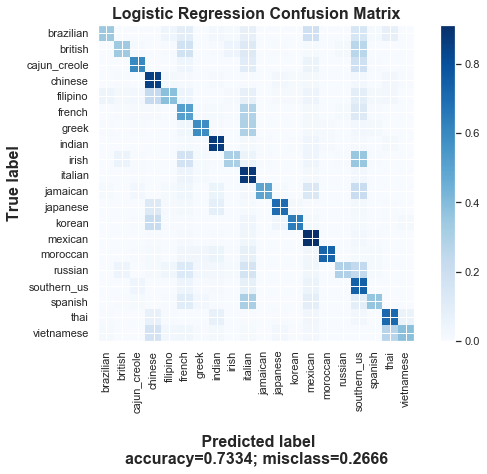

In [17]:
# Classification results using confusion matrix
cuisines = data['cuisine'].value_counts().index
labels = np.unique(y_test)

Logistic_Confusion = confusion_matrix(y_test, logistic.predict(X_test), labels = labels) # construct confusion matrix 
plot_confusion_matrix(Logistic_Confusion, target_names = labels, title = 'Logistic Regression Confusion Matrix')

In [18]:
# Calculation of weighted F1 score 
logit_f1 = f1_score(y_test, logistic.predict(X_test), average = 'weighted') # calculate F1 score

# Calculation of average accuracy score 
logit_acc = logistic.score(X_test, y_test)

print('f1-score=%.3f accuracy=%.3f' % (logit_f1, logit_acc))

f1-score=0.723 accuracy=0.733


# Random Forest Model

In [19]:
clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [20]:
grid_lr.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('sm',
                                        SMOTE(k_neighbors=5, kind='deprecated',
                                              m_neighbors='deprecated',
                                              n_jobs=1, out_step='deprecated',
                                              random_state=None, ratio=None,
                                              sampling_strategy='auto',
                                              svm_estimator='deprecated')),
                                       ('lr',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           in

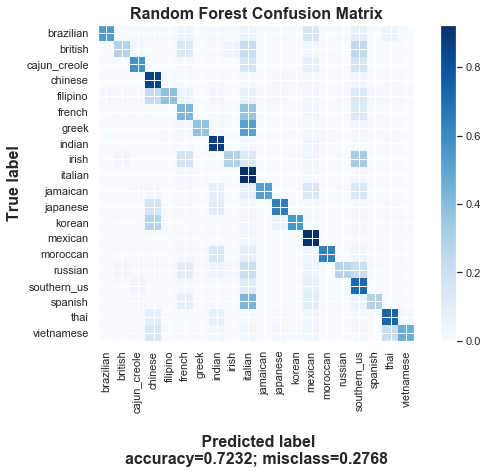

In [21]:
# Classification results using confusion matrix
cuisines = data['cuisine'].value_counts().index
labels = np.unique(y_test)

RF_Confusion = confusion_matrix(y_test, clf.predict(X_test), labels=labels) # construct confusion matrix 
plot_confusion_matrix(RF_Confusion, target_names=labels, title = 'Random Forest Confusion Matrix')

In [22]:
# Calculation of weighted F1 score 
RF_f1 = f1_score(y_test, clf.predict(X_test), average = 'weighted') # calculate F1 score

# Calculation of average accuracy score 
RF_acc = clf.score(X_test, y_test)

print('f1-score=%.3f accuracy=%.3f' % (RF_f1, RF_acc))

f1-score=0.707 accuracy=0.723
